In [7]:
# Standard libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.dpi'] = 300
import random
import csv
import pandas as pd
import h5py
import gc  # garbage collection
# Scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# PyTorch libraries
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize 
# Get dirs
import os
cwd = os.getcwd()# "Code" folder
master_dir = os.path.abspath(os.path.join(cwd, ".."))

When using __Google Colab__, run the following cell

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')
# code_dir = "/content/drive/MyDrive/KUL/MAI thesis/Code"
# master_dir = os.path.join(code_dir, "..")
# os.chdir(code_dir)
# print(os.getcwd())

In [9]:
# Load own scripts:
%load_ext autoreload
%autoreload 2
import physics
import data
import nnc2p

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Point towards the folder where we store the EOS tables (__Note:__ they are not in the Github as these are very large files)

In [10]:
eos_tables_dir = os.path.join("D:/Coding/Datasets/eos_tables")  # offline
# eos_tables_dir = os.path.join(master_dir, "Data")  # in Google Colab
print(f"Going to look for EOS tables at {eos_tables_dir}")

Going to look for EOS tables at D:/Coding/Datasets/eos_tables


For the training, check if GPU is available (Google Colab):

In [11]:
if torch.cuda.is_available(): 
    DEVICE = "cuda:0" 
    torch.set_default_device('cuda')
else: 
    DEVICE = "cpu" 
print(f"Device for training: {DEVICE}")

Device for training: cpu


# Introduction

Here, we try to find a way to generalize the NN approach from the first semester to the situation of tabular EOS. 

*Note*: We use HDF5 files, but you have to close them manually. Forgot to close one? Check if there is still an open HDF5 file with garbage collect in the memory, and close it:

In [222]:
# Browse through objects
for obj in gc.get_objects():
    # see if is an HDF5 file
    if isinstance(obj, h5py.File):
        print(obj)
        try:
            obj.close()
            del obj
        except:
            pass
gc.collect()

<Closed HDF5 file>
<Closed HDF5 file>
<Closed HDF5 file>
<Closed HDF5 file>


0

# Exploring EOS tables

In [86]:
# Put the downloaded EOS tables here
# first_table_filename       = "LS180_234r_136t_50y_analmu_20091212_SVNr26.h5"
# second_table_filename = "GShen_NL3EOS_rho280_temp180_ye52_version_1.1_20120817.h5"
third_table_filename      = "SLy4_0000_rho391_temp163_ye66.h5"
# Then specify which we are going to use here
eos_table_filename = third_table_filename

Read in the SLy4 EOS table using our py script: (make sure to close HDF5 files!)

In [96]:
# Open EOS table
eos_table = physics.read_eos_table(os.path.join(eos_tables_dir, eos_table_filename))
# Read in the most important variables and convert them to np arrays
dim_ye, dim_temp, dim_rho = eos_table["pointsye"][()][0], eos_table["pointstemp"][()][0], eos_table["pointsrho"][()][0]
logrho = eos_table["logrho"][()]
logtemp = eos_table["logtemp"][()]
ye = eos_table["ye"][()]
logpress = eos_table["logpress"][()]
logenergy = eos_table["logenergy"][()]
print(f"This EOS table has dimensions {dim_ye} x {dim_temp} x {dim_rho}")
# Small test to see the output of the EOS table
test_ye = eos_table["ye"][()][0]
test_temp = eos_table["logtemp"][()][0]
test_rho = eos_table["logrho"][()][0]
test_press, test_eps = eos_table["logpress"][()][0, 0, 0], eos_table["logenergy"][()][0, 0, 0]
print(f"Example: ({test_rho}, {test_temp}, {test_ye}) we have (log eps, log p): ({test_eps}, {test_press}).")
eos_table.close()

This EOS table has dimensions 66 x 163 x 391
Example: (3.0239960056064277, -3.0, 0.005) we have (log eps, log p): (19.2791052025363, 17.99956975587081).


See what is inside this EOS table

In [97]:
# # Iterate over keys and save them to list for simplified viewing
# keys = []
# for key in eos_table:
#     keys.append(key)
# print(keys)
# print(len(keys))

## Output
# ['Abar', 'Albar', 'MERGE-space.in', 'MERGE-src.tar.gz', 'MERGE-tables.in', 'MERGE-transition.in', 'SNA-skyrme.in', 'SNA-space.in', 'SNA-src.tar.gz', 'Xa', 'Xh', 'Xl', 'Xn', 'Xp', 'Zbar', 'Zlbar', 'cs2', 'dedt', 'dpderho', 'dpdrhoe', 'energy_shift', 'entropy', 'gamma', 'have_rel_cs2', 'logenergy', 'logpress', 'logrho', 'logtemp', 'meffn', 'meffp', 'mu_e', 'mu_n', 'mu_p', 'muhat', 'munu', 'pointsrho', 'pointstemp', 'pointsye', 'r', 'u', 'ye']

# Generating training data by sampling from EOS table

To generate new data

In [120]:
# dat = physics.generate_tabular_data(eos_table, number_of_points = 100000, save_name = "SLy4_training_data")
# dat = physics.generate_tabular_data(eos_table, number_of_points = 20000, save_name = "SLy4_test_data")

Load data

In [121]:
# df = pd.read_csv(os.path.join(master_dir, "Data/SLy4_training_data.csv"))
# df

The network architecture we will use:

In [44]:
class Net(nn.Module):
    """
    Implements a simple feedforward neural network.
    """
    def __init__(self, nb_of_inputs: int = 3, nb_of_outputs: int = 1, h: list = [600, 200], reg: bool = False, 
                 activation_function = torch.nn.Sigmoid) -> None:
        """
        Initialize the neural network class.
        """
        # Call the super constructor first
        super(Net, self).__init__()
        
        # For convenience, save the sizes of the hidden layers as fields as well
        self.h = h
        # Add visible layers as well: input is 3D and output is 1D
        self.h_augmented = [nb_of_inputs] + h + [nb_of_outputs]

        # Add field to specify whether or not we do regularization
        self.regularization = reg

        # Define the layers:
        for i in range(len(self.h_augmented)-1):
            if i == len(self.h_augmented)-2:
                setattr(self, f"linear{i+1}", nn.Linear(self.h_augmented[i], self.h_augmented[i+1], bias=False))
            else:
                setattr(self, f"linear{i+1}", nn.Linear(self.h_augmented[i], self.h_augmented[i+1]))
                setattr(self, f"activation{i+1}", activation_function())

    def forward(self, x):
        """
        Computes a forward step given the input x.
        :param x: Input for the neural network.
        :return: x: Output neural network
        """
        
        for i, module in enumerate(self.modules()):
            # The first module is the whole NNC2P object, continue
            if i == 0:
                continue
            x = module(x)

        return x

# First goal: NNEOS

__NNEOS__: try to replicate the EOS table (at least the core variables we are interested in) using the "input" variables rho, temp, ye.

For this, choose the output variables and convert the EOS table to the appropriate format, which has rows of examples

In [210]:
# Get the filename of converted training data
filename = os.path.join(eos_tables_dir, "train_eos_table.h5")

In [211]:
# # Create new dataset (if desired)
# # Specify output vars as "var_names" argument in this function - see physics.py
# physics.convert_eos_table(eos_table, save_name="train_eos_table_GShen.h5")

In [212]:
# Load the data
train_eos_table = h5py.File(filename, 'r')
# Get the data saved in the HDF5 file
features  = train_eos_table["features"][:]
labels    = train_eos_table["labels"][:]
var_names = train_eos_table["var_names"][:]
size_eos_table = len(features)
print(f"The output variables are {var_names}. Number of examples: {size_eos_table}")
# Close the file
train_eos_table.close()

The output variables are [b'logenergy' b'logpress']. Number of examples: 4206378


In [213]:
# test - how does output look like?
print(features[0])
print(labels[0])

[ 3.02399601 -3.          0.005     ]
[19.2791052  17.99956976]


Get the training data as DataSet and DataLoader objects. Note on normalization: we fit transform on the training data, then use the fitted scaler object to transform (i.e. using same transformation as the training data) the test set.

In [214]:
# For normalization, use sklearn's StandardScaler
scaler = StandardScaler()
# Do train test split here
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)
# "Cutoff": only use certain portion of the data for training and testing, to speed up training when tuning architecture 
cutoff = 0.025
print(len(train_features))
end = int(cutoff*len(train_features))
train_features = train_features[:end]
train_labels = train_labels[:end]
end = int(cutoff*len(test_features))
test_features = test_features[:end]
test_labels = test_labels[:end]
print(len(train_features))
# Convert to PyTorch Datasets as we defined them
train_dataset = data.HDF5Dataset(train_features, train_labels, normalization_function = scaler.fit_transform) 
test_dataset  = data.HDF5Dataset(test_features, test_labels, normalization_function = scaler.transform)
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size = 32)
test_dataloader  = DataLoader(test_dataset, batch_size = 32)

3154783
78869


Create a new instance of the Net:

In [215]:
model = Net(nb_of_inputs=3, nb_of_outputs=2, h=[50, 50]).double()
# print(next(model.parameters()).is_cuda )

In [216]:
nnc2p.count_parameters(model)

2850

Create a trainer object:

In [217]:
trainer = nnc2p.Trainer(model, 1e-2, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

Train the network

In [223]:
trainer.train()

Training the model for 500 epochs.

 Epoch 0 
 --------------
Train loss: 2.66E-02
Test  loss: 2.68E-02

 Epoch 1 
 --------------
Train loss: 6.59E-03
Test  loss: 6.65E-03

 Epoch 2 
 --------------
Train loss: 5.87E-03
Test  loss: 5.94E-03

 Epoch 3 
 --------------
Train loss: 5.61E-03
Test  loss: 5.74E-03

 Epoch 4 
 --------------
Train loss: 4.30E-03
Test  loss: 4.34E-03

 Epoch 5 
 --------------
Train loss: 3.52E-03
Test  loss: 3.55E-03

 Epoch 6 
 --------------
Train loss: 2.28E-03
Test  loss: 2.29E-03

 Epoch 7 
 --------------
Train loss: 2.00E-03
Test  loss: 2.00E-03

 Epoch 8 
 --------------
Train loss: 2.12E-03
Test  loss: 2.11E-03

 Epoch 9 
 --------------
Train loss: 4.37E-03
Test  loss: 4.34E-03

 Epoch 10 
 --------------
Train loss: 3.62E-03
Test  loss: 3.60E-03

 Epoch 11 
 --------------
Train loss: 4.41E-03
Test  loss: 4.39E-03

 Epoch 12 
 --------------
Adapting learning rate to 0.005
Train loss: 4.34E-03
Test  loss: 4.33E-03

 Epoch 13 
 --------------
Train

Train loss: 1.56E-04
Test  loss: 1.56E-04

 Epoch 117 
 --------------
Train loss: 1.55E-04
Test  loss: 1.56E-04

 Epoch 118 
 --------------
Train loss: 1.55E-04
Test  loss: 1.55E-04

 Epoch 119 
 --------------
Train loss: 1.54E-04
Test  loss: 1.55E-04

 Epoch 120 
 --------------
Train loss: 1.54E-04
Test  loss: 1.54E-04

 Epoch 121 
 --------------
Train loss: 1.53E-04
Test  loss: 1.54E-04

 Epoch 122 
 --------------
Train loss: 1.53E-04
Test  loss: 1.53E-04

 Epoch 123 
 --------------
Train loss: 1.52E-04
Test  loss: 1.53E-04

 Epoch 124 
 --------------
Train loss: 1.52E-04
Test  loss: 1.52E-04

 Epoch 125 
 --------------
Train loss: 1.51E-04
Test  loss: 1.52E-04

 Epoch 126 
 --------------
Train loss: 1.51E-04
Test  loss: 1.51E-04

 Epoch 127 
 --------------
Train loss: 1.50E-04
Test  loss: 1.51E-04

 Epoch 128 
 --------------
Train loss: 1.50E-04
Test  loss: 1.50E-04

 Epoch 129 
 --------------
Train loss: 1.49E-04
Test  loss: 1.50E-04

 Epoch 130 
 --------------
Train 

Train loss: 8.55E-05
Test  loss: 8.61E-05

 Epoch 232 
 --------------
Train loss: 8.54E-05
Test  loss: 8.60E-05

 Epoch 233 
 --------------
Train loss: 8.52E-05
Test  loss: 8.58E-05

 Epoch 234 
 --------------
Train loss: 8.51E-05
Test  loss: 8.57E-05

 Epoch 235 
 --------------
Train loss: 8.50E-05
Test  loss: 8.56E-05

 Epoch 236 
 --------------
Train loss: 8.48E-05
Test  loss: 8.54E-05

 Epoch 237 
 --------------
Train loss: 8.47E-05
Test  loss: 8.53E-05

 Epoch 238 
 --------------
Train loss: 8.46E-05
Test  loss: 8.52E-05

 Epoch 239 
 --------------
Train loss: 8.44E-05
Test  loss: 8.50E-05

 Epoch 240 
 --------------
Train loss: 8.43E-05
Test  loss: 8.49E-05

 Epoch 241 
 --------------
Train loss: 8.42E-05
Test  loss: 8.48E-05

 Epoch 242 
 --------------
Train loss: 8.40E-05
Test  loss: 8.46E-05

 Epoch 243 
 --------------
Train loss: 8.39E-05
Test  loss: 8.45E-05

 Epoch 244 
 --------------
Train loss: 8.38E-05
Test  loss: 8.44E-05

 Epoch 245 
 --------------
Train 

Train loss: 7.37E-05
Test  loss: 7.43E-05

 Epoch 348 
 --------------
Train loss: 7.36E-05
Test  loss: 7.42E-05

 Epoch 349 
 --------------
Train loss: 7.35E-05
Test  loss: 7.41E-05

 Epoch 350 
 --------------
Train loss: 7.34E-05
Test  loss: 7.40E-05

 Epoch 351 
 --------------
Train loss: 7.33E-05
Test  loss: 7.39E-05

 Epoch 352 
 --------------
Train loss: 7.32E-05
Test  loss: 7.38E-05

 Epoch 353 
 --------------
Train loss: 7.31E-05
Test  loss: 7.37E-05

 Epoch 354 
 --------------
Train loss: 7.30E-05
Test  loss: 7.36E-05

 Epoch 355 
 --------------
Train loss: 7.29E-05
Test  loss: 7.35E-05

 Epoch 356 
 --------------
Train loss: 7.28E-05
Test  loss: 7.34E-05

 Epoch 357 
 --------------
Train loss: 7.27E-05
Test  loss: 7.33E-05

 Epoch 358 
 --------------
Train loss: 7.26E-05
Test  loss: 7.32E-05

 Epoch 359 
 --------------
Train loss: 7.25E-05
Test  loss: 7.31E-05

 Epoch 360 
 --------------
Train loss: 7.24E-05
Test  loss: 7.30E-05

 Epoch 361 
 --------------
Train 

Train loss: 6.32E-05
Test  loss: 6.37E-05

 Epoch 464 
 --------------
Train loss: 6.31E-05
Test  loss: 6.36E-05

 Epoch 465 
 --------------
Train loss: 6.30E-05
Test  loss: 6.36E-05

 Epoch 466 
 --------------
Train loss: 6.29E-05
Test  loss: 6.35E-05

 Epoch 467 
 --------------
Train loss: 6.28E-05
Test  loss: 6.34E-05

 Epoch 468 
 --------------
Train loss: 6.28E-05
Test  loss: 6.33E-05

 Epoch 469 
 --------------
Train loss: 6.27E-05
Test  loss: 6.33E-05

 Epoch 470 
 --------------
Train loss: 6.26E-05
Test  loss: 6.32E-05

 Epoch 471 
 --------------
Train loss: 6.25E-05
Test  loss: 6.31E-05

 Epoch 472 
 --------------
Train loss: 6.25E-05
Test  loss: 6.30E-05

 Epoch 473 
 --------------
Train loss: 6.24E-05
Test  loss: 6.29E-05

 Epoch 474 
 --------------
Train loss: 6.23E-05
Test  loss: 6.29E-05

 Epoch 475 
 --------------
Train loss: 6.22E-05
Test  loss: 6.28E-05

 Epoch 476 
 --------------
Train loss: 6.21E-05
Test  loss: 6.27E-05

 Epoch 477 
 --------------
Train 

Report architecture (this saves info to a CSV, such as hidden layer set-up, nb of epochs trained, loss after training,... in order to compare performances across different architecture details).

In [226]:
# trainer.report_training("NNEOS_tab_experiments.csv", comment = "eps and p.")

If desired, save the model

In [227]:
# torch.save(model.state_dict, "tabular_eos_50_50.pth")

Create a quick sketch of training

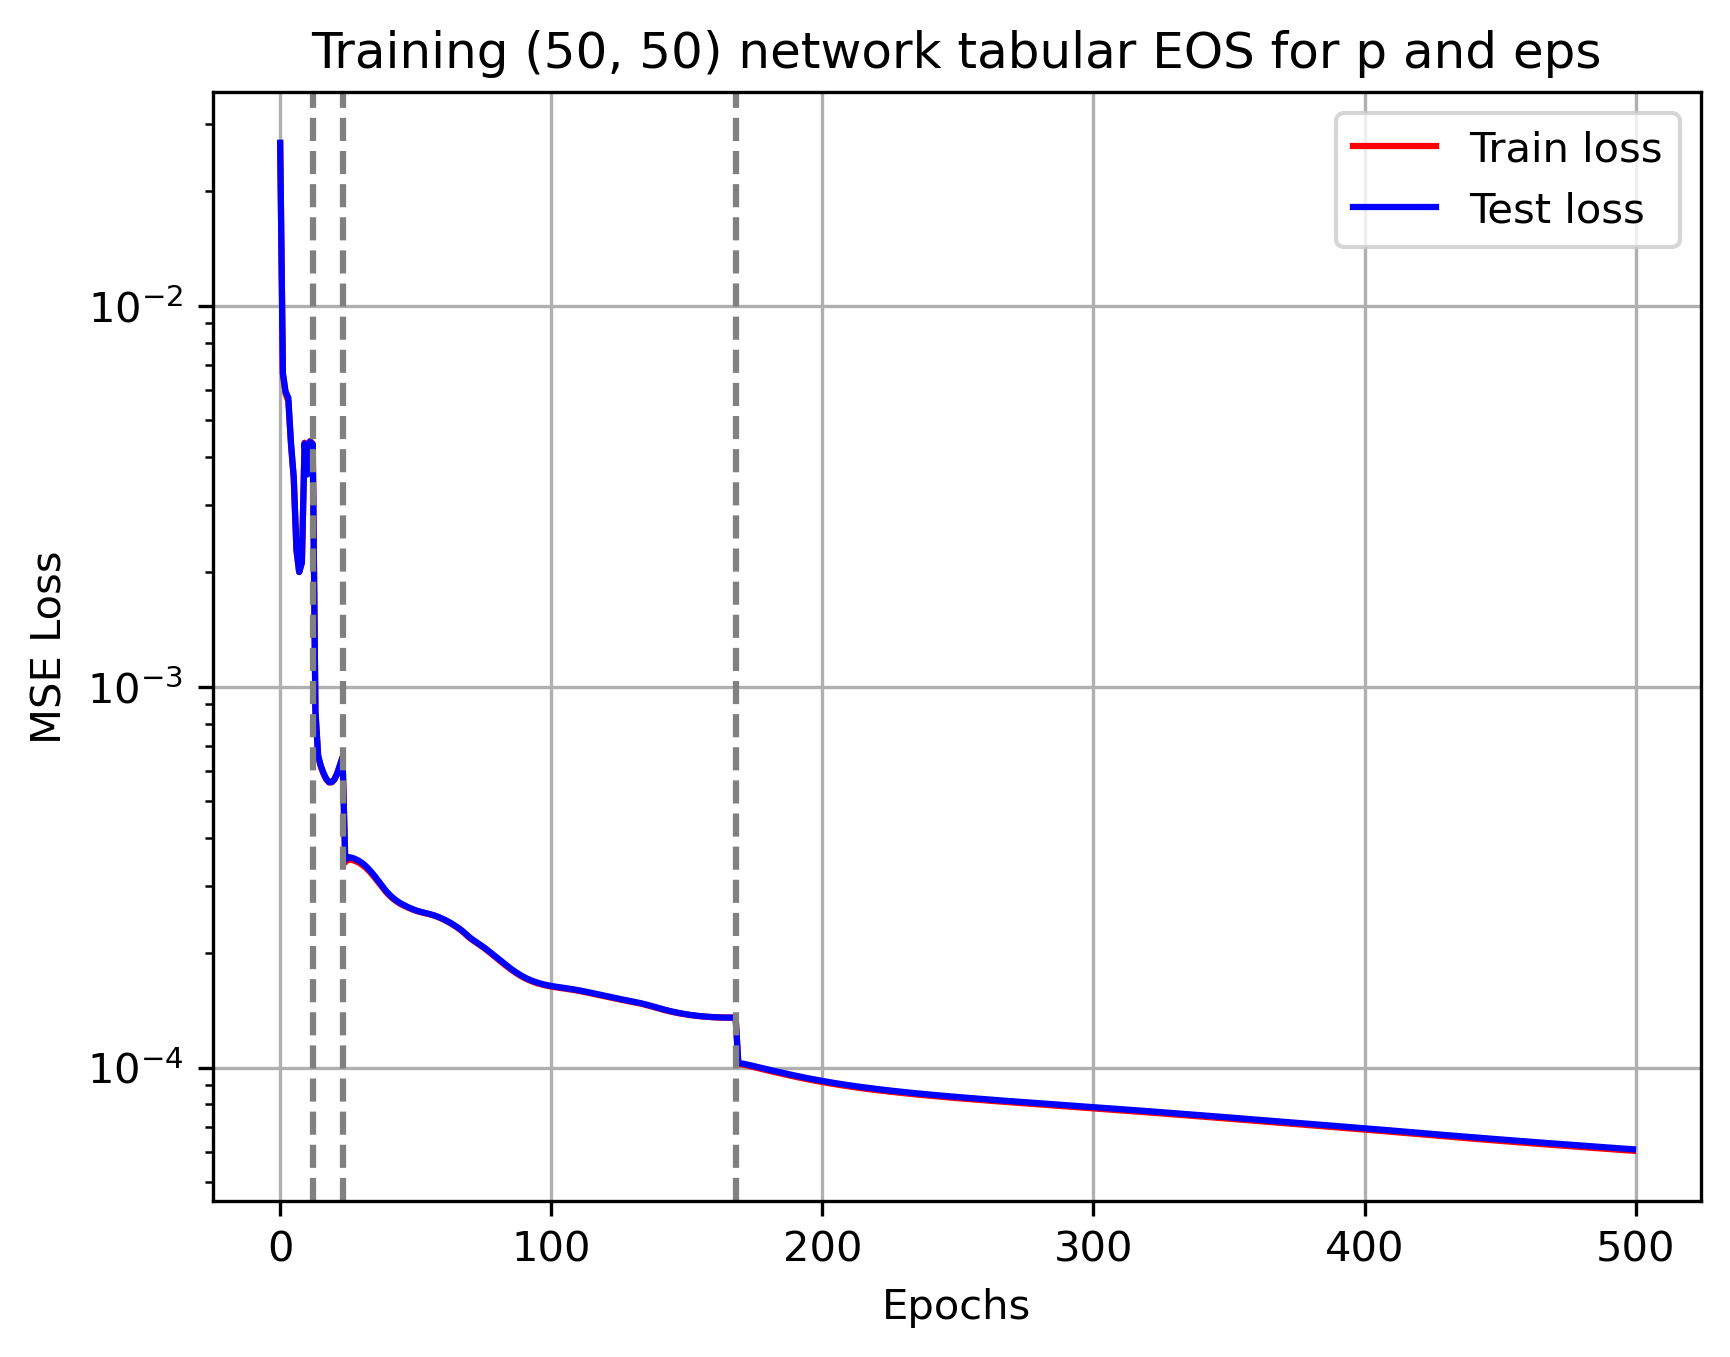

In [229]:
# plt.plot(trainer.train_losses, color='red', label="Train loss")
# plt.plot(trainer.test_losses, color='blue', label="Test loss")

# plt.grid()
# plt.legend()
# for ind in trainer.adaptation_indices:
#     plt.axvline(ind, ls = '--', color='grey')
# plt.yscale('log')
# plt.xlabel("Epochs")
# plt.ylabel("MSE Loss")
# plt.title("Training (50, 50) network tabular EOS for p and eps")
# plt.savefig("testing_training_tab_eos_network_50_50.pdf", bbox_inches = 'tight')
# plt.show()

## Measure performance

If desired, load the original architecture (`tabular_eos_14_04.pth` contains for h = 50, 100, 20). 

In [230]:
# model = Net(nb_of_inputs=3, nb_of_outputs=2, h=[50, 100, 20]).double()
# # Load the state dict
# state_dict = torch.load("tabular_eos_14_04.pth") 
# # Accidentally saved the method, so make call to convert to dict for params before loading
# state_dict = state_dict()
# model.load_state_dict(state_dict)

We see (by running the cell below several times) that network is quite robust in generalization, althought the $\ell_\infty$ norm can sometimes suddenly get quite high, so further investigation into training on the full table is needed.

In [231]:
# Sample features and their labels
n_samples = 10000
sample_ind = np.random.choice(len(features), size=min(len(features), n_samples), replace=False)
sample_features = features[sample_ind]
sample_labels = labels[sample_ind]
# Get predictions
with torch.no_grad():
    # Don't forget to apply normalization!!! We fixed the random seed for reproducibility
    sample_features = scaler.transform(sample_features)
    predictions = model(torch.from_numpy(sample_features))
    predictions = predictions.numpy()
    
# print(sample_labels[0])
# print(predictions[0])
print("L2       difference on sample: ", nnc2p.l2_norm(sample_labels, predictions))
# print(nnc2p.l1_norm(sample_labels, predictions))
print("Linfty difference on sample: ",nnc2p.linfty_norm(sample_labels, predictions))

L2       difference on sample:  [2.88110098e-05 8.95678498e-05]
Linfty difference on sample:  [0.03609999 0.08907174]


Don't forget normalization (note: we can export the normalization procedure later on by saving the mean and std).

In [95]:
print(f"Mean: {scaler.mean_}, std: {scaler.scale_}")

Mean: [ 9.52781415 -0.30129624  0.33031159], std: [3.76337654 1.56553371 0.19007265]


## Compare network with trilinear interpolation

We use scipy for the interpolation: see [this docs page](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interpn.html#scipy.interpolate.interpn)

In [99]:
from scipy.interpolate import interpn

In [108]:
def randomn(a, b):
    """Generate a random number in the range [a, b]"""
    
    return a + (b-a)*np.random.rand()

We define our own trilinear interpolation routine based on scipy:

In [232]:
def trilinear_interpolation(points, values_list, test_points):
    """
    Does a single prediction using trilinear interpolation.
    """
    # Make the predictions
    predictions = [interpn(points, values, test_points) for values in values_list]            
    # Return transpose: shape is (n_samples, n_vars) similar to neural network
    return np.transpose(np.array(predictions))

For the grid points, we reverse the order compared to the EOS table. That is, the EOS table uses (ye, logtemp, logrho), but we will use (logrho, logtemp, ye).

In [233]:
logpress_reversed = np.swapaxes(logpress, 0, 2)
logenergy_reversed = np.swapaxes(logenergy, 0, 2)
print(logpress_reversed.shape)

(391, 163, 66)


In [234]:
def sample_eos(logrho, logtemp, ye, n_examples = 1):
    """
    Simple auxiliary function that returns a random data point located in an EOS table, based on the (logrho, logtemp, ye) values.
    """
    
    return np.stack([[randomn(min(logrho), max(logrho)), randomn(min(logtemp), max(logtemp)), randomn(min(ye), max(ye))] for _ in range(n_examples)])

In [239]:
# Get an array of test cases:
n_examples = 10000
test_points = sample_eos(logrho, logtemp, ye, n_examples=n_examples)
# Grid of tables
points = (logrho, logtemp, ye)
# Variables we wish to get
values_list = [logenergy_reversed, logpress_reversed]
# Interpolation
interpolated = trilinear_interpolation(points, values_list, test_points)
# print(interpolated)  # print in case n_examples is low
# Compare with neural net
with torch.no_grad():
    # Don't forget normalization!!!
    test_points_n = scaler.transform(test_points)
    predictions = model(torch.from_numpy(test_points_n).double())
    predictions = predictions.numpy()
#     print(predictions)  # print in case n_examples is low

Now get error rates

In [240]:
l1_error, l2_error, linfty_error = nnc2p.l1_norm(interpolated, predictions), nnc2p.l2_norm(interpolated, predictions), nnc2p.linfty_norm(interpolated, predictions)

In [241]:
print(l1_error)
print(l2_error)
print(linfty_error)

[0.0039517  0.00686148]
[2.85792849e-05 8.73832172e-05]
[0.03501874 0.09598388]


## Compare performance of methods

Here, we will try to compare the performance of the methods:

In [271]:
# Get a single point that has to be predicted
test_point = sample_eos(logrho, logtemp, ye)
# Which values to predict?
values_list = [logenergy_reversed]

Performance of trilinear interpolation with Scipy:

In [272]:
# %timeit -r10 -n10000 trilinear_interpolation(points, values_list, test_point)
%timeit -r10 -n10000 interpn(points, logenergy_reversed, test_point)

260 µs ± 13.4 µs per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


Performance of the neural net (don't time normalization and conversion to torch, only the prediction stage)

In [273]:
test_point_n = scaler.transform(test_point)
test_point_torch = torch.from_numpy(test_point_n).double()

In [274]:
%timeit -r10 -n10000 model(test_point_torch)

94.9 µs ± 1.85 µs per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


Other comparison: the neural network but just the matrices!

In [275]:
w1 = model.state_dict()["linear1.weight"].numpy()
b1 = model.state_dict()["linear1.bias"].numpy()
w2 = model.state_dict()["linear2.weight"].numpy()
b2 = model.state_dict()["linear2.bias"].numpy()
w3 = model.state_dict()["linear3.weight"].numpy()

In [283]:
test_point[0]

array([12.09549806,  0.07115531,  0.38108956])

In [277]:
b1.shape

(50,)

In [278]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [279]:
def run_nn(x):
    x = np.matmul(w1, x) + b1
    x = sigmoid(x)
    x = np.matmul(w2, x) + b2
    x = sigmoid(x)
    x = np.matmul(w3, x)
    
    return x

In [280]:
print(test_point)
test1 = run_nn(test_point[0])
print(test1)
with torch.no_grad():
    test2 = model(torch.from_numpy(test_point[0]).double())
    test2 = test2.numpy()
print(test2)

[[12.09549806  0.07115531  0.38108956]]
[23.49345621 39.63100178]
[23.49345621 39.63100178]


In [286]:
%timeit -r10 -n10000 run_nn(test_point[0])

18.3 µs ± 4.15 µs per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


Is the network faster if we disable torch grad?

In [284]:
with torch.no_grad():
    %timeit -r10 -n10000 model(test_point_torch)

67.1 µs ± 2.76 µs per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


# Second goal: NNC2P

__TO DO__ think about design of architecture AND fix the conserved variable values -- I think they were not computed correctly before! 

__NNC2P__: try to replicate the full C2P conversion.

Get the training data as DataSet and DataLoader objects. Note on normalization: we fit transform on the training data, then use the fitted scaler object to transform (i.e. using same transformation as the training data) the test set.

In [ ]:
# Give the names of the input vars (features) and output vars (labels)
in_vars = ["rho", "eps", "ye"]
out_vars = ["temp"]
# For normalization, use sklearn's StandardScaler
scaler = StandardScaler()
# Read the sampled data as pandas dataframes
train_df = pd.read_csv(os.path.join(master_dir, "Data/SLy4_training_data.csv"))
test_df  = pd.read_csv(os.path.join(master_dir, "Data/SLy4_test_data.csv"))
# Convert to PyTorch Datasets as we defined them
train_dataset = data.CustomDataset(train_df, feature_names = in_vars, label_names = out_vars, normalization_function = scaler.fit_transform) 
test_dataset  = data.CustomDataset(test_df, feature_names = in_vars, label_names = out_vars, normalization_function = scaler.transform)
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader  = DataLoader(test_dataset, batch_size=32)

Create a new instance of the Net:

In [ ]:
model = Net(nb_of_inputs = 3, nb_of_outputs = 1, h=[50, 50])
model

Net(
  (linear1): Linear(in_features=3, out_features=50, bias=True)
  (activation1): Sigmoid()
  (linear2): Linear(in_features=50, out_features=50, bias=True)
  (activation2): Sigmoid()
  (linear3): Linear(in_features=50, out_features=1, bias=False)
)

In [ ]:
nnc2p.count_parameters(model)

2800

Create a trainer object from it:

In [ ]:
trainer = nnc2p.Trainer(model, 1e-1, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

In [ ]:
trainer.train()

Training the model for 500 epochs.

 Epoch 0 
 --------------
Train loss: 7.59E-01
Test  loss: 7.62E-01

 Epoch 1 
 --------------
Train loss: 9.92E-01
Test  loss: 9.98E-01

 Epoch 2 
 --------------
Train loss: 9.45E-01
Test  loss: 9.61E-01

 Epoch 3 
 --------------
Train loss: 8.24E-01
Test  loss: 8.29E-01

 Epoch 4 
 --------------
Train loss: 9.10E-01
Test  loss: 9.16E-01

 Epoch 5 
 --------------
Train loss: 8.80E-01
Test  loss: 8.91E-01

 Epoch 6 
 --------------
Train loss: 8.62E-01
Test  loss: 8.67E-01

 Epoch 7 
 --------------
Train loss: 8.20E-01
Test  loss: 8.27E-01

 Epoch 8 
 --------------
Train loss: 8.80E-01
Test  loss: 8.94E-01

 Epoch 9 
 --------------
Train loss: 9.20E-01
Test  loss: 9.26E-01

 Epoch 10 
 --------------
Train loss: 7.34E-01
Test  loss: 7.39E-01

 Epoch 11 
 --------------
Train loss: 7.48E-01
Test  loss: 7.56E-01

 Epoch 12 
 --------------
Train loss: 7.28E-01
Test  loss: 7.31E-01

 Epoch 13 
 --------------
Train loss: 8.87E-01
Test  loss: 8.99

KeyboardInterrupt: 

Create a quick sketch of training

In [ ]:
# plt.plot(trainer.train_losses, color='red', label="Train loss")
# plt.plot(trainer.test_losses, color='blue', label="Test loss")

# plt.grid()
# plt.legend()
# for ind in trainer.adaptation_indices:
#     plt.axvline(ind, ls = '--', color='grey')
# plt.yscale('log')
# plt.xlabel("Epochs")
# plt.xlabel("MSE Loss")
# plt.title("Training (100, 100) network tabular EOS for p and eps")
# plt.savefig("testing_training_tab_eos_network_100_100.pdf", bbox_inches = 'tight')
# plt.show()

# Archive: NNE2T

__NNE2T__: try to replicate the conversion from energy to temperature, which is currently done by rootfinding approximations & lookups in the EOS table (see Gmunu code). It seemed harder than I initially thought to model and train this; and in the end, I'm not sure how useful it'll be, so I'm archiving this.

Get the training data as DataSet and DataLoader objects. Note on normalization: we fit transform on the training data, then use the fitted scaler object to transform (i.e. using same transformation as the training data) the test set.

In [ ]:
# Give the names of the input vars (features) and output vars (labels)
in_vars = ["rho", "eps", "ye"]
out_vars = ["temp"]
# For normalization, use sklearn's StandardScaler
scaler = StandardScaler()
# Read the sampled data as pandas dataframes
train_df = pd.read_csv(os.path.join(master_dir, "Data/SLy4_training_data.csv"))
test_df  = pd.read_csv(os.path.join(master_dir, "Data/SLy4_test_data.csv"))
# Convert to PyTorch Datasets as we defined them
train_dataset = data.CustomDataset(train_df, feature_names = in_vars, label_names = out_vars, normalization_function = scaler.fit_transform) 
test_dataset  = data.CustomDataset(test_df, feature_names = in_vars, label_names = out_vars, normalization_function = scaler.transform)
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader  = DataLoader(test_dataset, batch_size=32)

Create a new instance of the Net:

In [ ]:
model = Net(nb_of_inputs = 3, nb_of_outputs = 1, h=[50, 50])
model

Net(
  (linear1): Linear(in_features=3, out_features=50, bias=True)
  (activation1): Sigmoid()
  (linear2): Linear(in_features=50, out_features=50, bias=True)
  (activation2): Sigmoid()
  (linear3): Linear(in_features=50, out_features=1, bias=False)
)

In [ ]:
nnc2p.count_parameters(model)

2800

Create a trainer object from it:

In [ ]:
trainer = nnc2p.Trainer(model, 1e-1, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

In [ ]:
trainer.train()

Training the model for 500 epochs.

 Epoch 0 
 --------------
Train loss: 7.59E-01
Test  loss: 7.62E-01

 Epoch 1 
 --------------
Train loss: 9.92E-01
Test  loss: 9.98E-01

 Epoch 2 
 --------------
Train loss: 9.45E-01
Test  loss: 9.61E-01

 Epoch 3 
 --------------
Train loss: 8.24E-01
Test  loss: 8.29E-01

 Epoch 4 
 --------------
Train loss: 9.10E-01
Test  loss: 9.16E-01

 Epoch 5 
 --------------
Train loss: 8.80E-01
Test  loss: 8.91E-01

 Epoch 6 
 --------------
Train loss: 8.62E-01
Test  loss: 8.67E-01

 Epoch 7 
 --------------
Train loss: 8.20E-01
Test  loss: 8.27E-01

 Epoch 8 
 --------------
Train loss: 8.80E-01
Test  loss: 8.94E-01

 Epoch 9 
 --------------
Train loss: 9.20E-01
Test  loss: 9.26E-01

 Epoch 10 
 --------------
Train loss: 7.34E-01
Test  loss: 7.39E-01

 Epoch 11 
 --------------
Train loss: 7.48E-01
Test  loss: 7.56E-01

 Epoch 12 
 --------------
Train loss: 7.28E-01
Test  loss: 7.31E-01

 Epoch 13 
 --------------
Train loss: 8.87E-01
Test  loss: 8.99

KeyboardInterrupt: 

Create a quick sketch of training

In [ ]:
# plt.plot(trainer.train_losses, color='red', label="Train loss")
# plt.plot(trainer.test_losses, color='blue', label="Test loss")

# plt.grid()
# plt.legend()
# for ind in trainer.adaptation_indices:
#     plt.axvline(ind, ls = '--', color='grey')
# plt.yscale('log')
# plt.xlabel("Epochs")
# plt.xlabel("MSE Loss")
# plt.title("Training (100, 100) network tabular EOS for p and eps")
# plt.savefig("testing_training_tab_eos_network_100_100.pdf", bbox_inches = 'tight')
# plt.show()